In [2]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *

In [3]:
def analyze_individual_checkpoint(checkpoint, task, all_args):
    """For a given checkpoint and set of analysis args, analyses that one checkpoint.

    Analysis includes finding the fixed points, clustering them, and extracting
    autonomous and input-driven transition probabilities."""

    FP_args = {k.split('FP_')[1]: all_args[k]
           for k in all_args.keys() if 'FP_' in k}
    test_args = {k.split('test_')[1]: all_args[k]
                 for k in all_args.keys() if 'test_' in k}
    graph_args = {k.split('graph_')[1]: all_args[k]
                  for k in all_args.keys() if 'graph_' in k}

    if FP_args['find_FPs']:
        analysis_args = {k: FP_args[k] for k in FP_args if k != 'find_FPs'}
        analyze_checkpoint(checkpoint, data, verbose=False,
                           parallelize=True, **analysis_args)

        get_graph_structure(checkpoint, parallelize=True,
                            background_input=0,  **graph_args)
        get_input_dependent_graph_structure(checkpoint,
                                            inputs=task.probe_inputs,
                                            **graph_args)

    if test_args['save_data']:
        np.random.seed(0)
        test_data = task.gen_data(10, test_args['N'])
        test_sim = Simulation(checkpoint['rnn'])
        test_sim.run(test_data, mode='test', verbose=False,
                     monitors=['rnn.a'],
                     a_initial=np.zeros(checkpoint['rnn'].n_h))
        checkpoint['test_data'] = test_sim.mons['rnn.a']
        U, S, V = np.linalg.svd(test_sim.mons['rnn.a'])
        checkpoint['V'] = V.T[:, :test_args['n_PCs']]

    return checkpoint

In [59]:
### --- NORMAL TRAINED NETWORK --- ###

task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 20000
N_test = 2000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0.01, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 0.5s 
Test loss: 0.6468427593577005 

Progress: 20.0% complete 
Time Elapsed: 1.0s 
Test loss: 0.3638219487470463 

Progress: 30.0% complete 
Time Elapsed: 1.6s 
Test loss: 0.027100436196752068 

Progress: 40.0% complete 
Time Elapsed: 2.2s 
Test loss: 0.010387964457301413 

Progress: 50.0% complete 
Time Elapsed: 2.7s 
Test loss: 0.14739620435074136 

Progress: 60.0% complete 
Time Elapsed: 3.3s 
Test loss: 0.006338764464885693 

Progress: 70.0% complete 
Time Elapsed: 3.8s 
Test loss: 0.005073522683268919 

Progress: 80.0% complete 
Time Elapsed: 4.4s 
Test loss: 0.004519896752712832 

Progress: 90.0% complete 
Time Elapsed: 5.0s 
Test loss: 0.004786212088070944 



In [60]:
checkpoint = sim.checkpoints[N_train - 1]

In [50]:
### --- CENI-LIVI HAND SOLUTION --- ###

task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 10
N_test = 2000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

W_in, W_rec, W_out, b_rec, b_out = Flip_Flop_Ceni_Livi_solution(2, 1, 3)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 0.0s 
Test loss: 0.33118116820353755 

Progress: 20.0% complete 
Time Elapsed: 0.1s 
Test loss: 0.33118116134187003 

Progress: 30.0% complete 
Time Elapsed: 0.1s 
Test loss: 0.33118115844189155 

Progress: 40.0% complete 
Time Elapsed: 0.2s 
Test loss: 0.33118115720345254 

Progress: 50.0% complete 
Time Elapsed: 0.3s 
Test loss: 0.3324833268535819 

Progress: 60.0% complete 
Time Elapsed: 0.4s 
Test loss: 0.3324835009067251 

Progress: 70.0% complete 
Time Elapsed: 0.4s 
Test loss: 0.33248393997690273 

Progress: 80.0% complete 
Time Elapsed: 0.5s 
Test loss: 0.3324915139052433 

Progress: 90.0% complete 
Time Elapsed: 0.6s 
Test loss: 0.3324946845797692 



In [51]:
checkpoint = sim.checkpoints[N_train - 1]

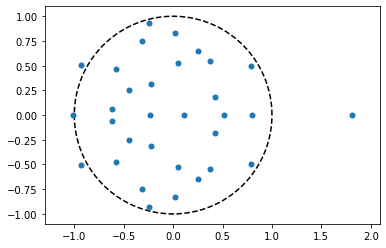

In [101]:
### --- RANDOM GAUSSIAN --- ###

g = 1

task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 10
N_test = 2000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = g * np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

n_outliers = 6
thetas = np.random.normal(0, 1, n_outliers)

m = np.random.normal(0, 1, n_hidden)
n = (1 / n_hidden) * sum([thetas[k] / g ** (2 * k) * np.linalg.matrix_power(W_rec, k).dot(m)
                          for k in range(n_outliers)])



#eigs, vecs = np.linalg.eig(W_rec)
#n = np.real(vecs[0]) + np.random.normal(0, 0.001, n_hidden)
#n = np.random.normal(0, 1, n_hidden)
#m = np.random.normal(0, 1, n_hidden)
W_rec = W_rec + np.multiply.outer(m, n)

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=False,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

%matplotlib inline
plot_eigenvalues(W_rec)

In [95]:
checkpoint = sim.checkpoints[N_train - 1]

In [96]:
all_args = get_default_args()
all_args['FP_N'] = 600
all_args['FP_same_LR_criterion'] = 2000
analyzed_checkpoint = analyze_individual_checkpoint(checkpoint=checkpoint, task=task, all_args=all_args)

Analyzing checkpoint 9...
Reached same LR criterion at 2009 iterReached same LR criterion at 2015 iterReached same LR criterion at 2010 iterReached same LR criterion at 2011 iterReached same LR criterion at 2012 iterReached same LR criterion at 2010 iter
Reached same LR criterion at 2009 iter
Reached same LR criterion at 2009 iter
Reached same LR criterion at 2010 iter
Reached same LR criterion at 2009 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2011 iterReached same LR criterion at 2012 iterReached same LR criterion at 2009 iter











Reached same LR criterion at 2010 iterReached same LR criterion at 2009 iterReached same LR criterion at 2009 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2013 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iterReached 

Reached same LR criterion at 3981 iterReached same LR criterion at 2009 iterReached same LR criterion at 2013 iterReached same LR criterion at 2010 iterReached same LR criterion at 2013 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iter
Reached same LR criterion at 2009 iter
Reached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iter


Reached same LR criterion at 2010 iterReached same LR criterion at 2009 iter









Reached same LR criterion at 2010 iterReached same LR criterion at 3983 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iterReached same LR criterion at 2015 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 i

Reached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iter
Reached same LR criterion at 2012 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iterReached same LR criterion at 2010 iter
Reached same LR criterion at 2009 iter

Reached same LR criterion at 2011 iter
Reached same LR criterion at 2012 iter
Reached same LR criterion at 2010 iterReached same LR criterion at 2010 iterReached same LR criterion at 2009 iter








Reached same LR criterion at 2009 iterReached same LR criterion at 3984 iterReached same LR criterion at 2016 iter

Reached same LR criterion at 2015 iter
Reached same LR criterion at 2011 iterReached same LR criterion at 2012 iterReached same LR criterion at 2009 iterReached same LR criterion at 2015 iter
Reached same LR criterion at 2014 iterReached same LR criterion at 2009 iterReached same LR criterion at 20

<IPython.core.display.Javascript object>


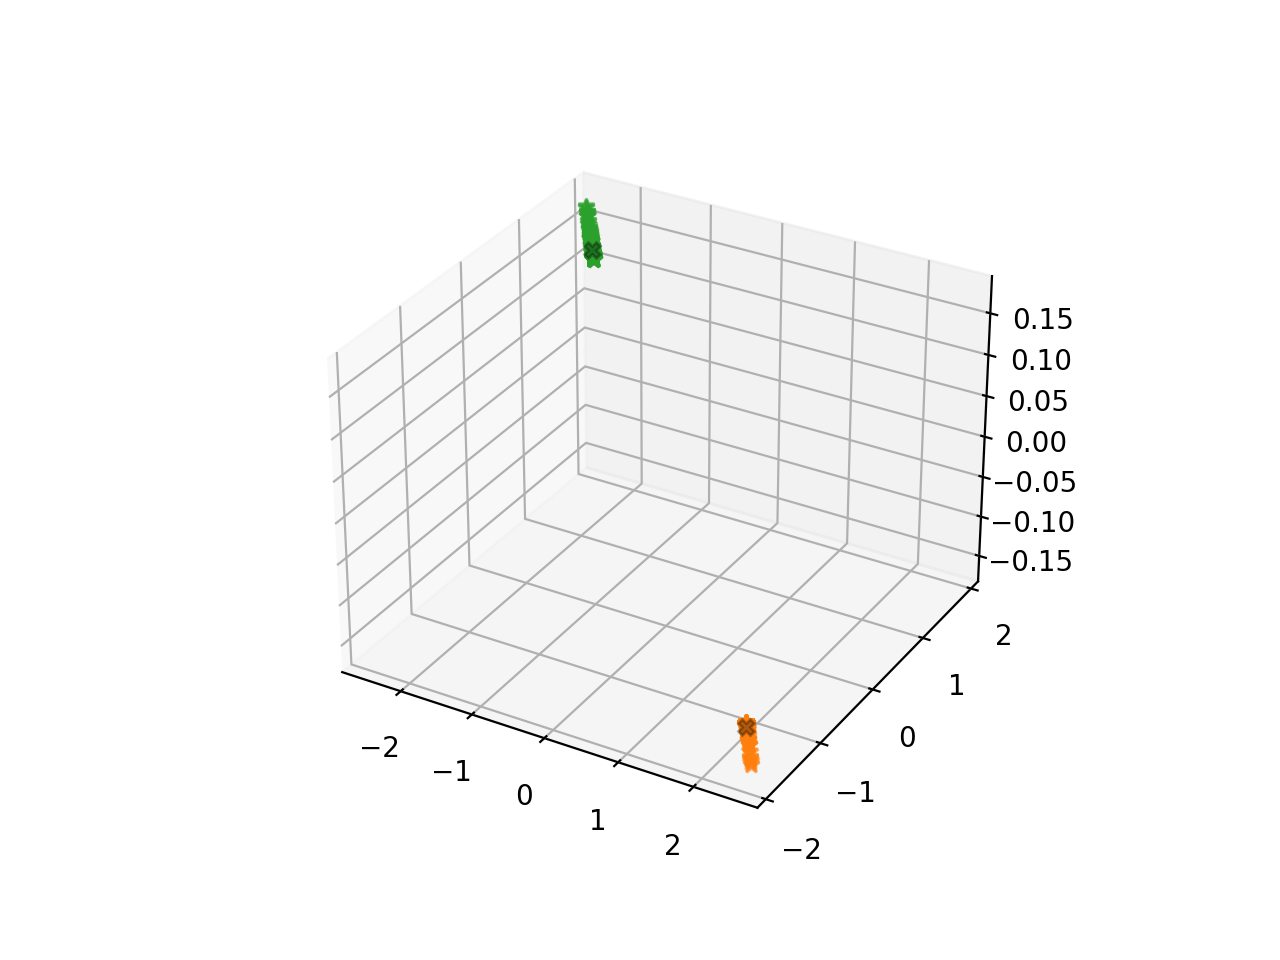

In [97]:
%matplotlib notebook
ssa = plot_checkpoint_results(analyzed_checkpoint, data, plot_test_points=False,
                              plot_fixed_points=True, plot_cluster_means=True,
                              plot_uncategorized_points=False,
                              plot_init_points=False, eig_norm_color=False,
                              plot_graph_structure=True,
                              n_vae_samples=None,
                              n_test_samples=None,
                              graph_key='adjacency_matrix')

In [98]:
figs_path = 'figs/single_checkpoints/'
ssa.fig.savefig(os.path.join(figs_path, 'g=1_perturb_corr6_line.pdf'))
